**Checkout my [first](https://www.kaggle.com/code/neelkamal692/quora-duplicate-question-baseline) notebook to see the performance with baseline model without any preprocessing**

**Here is me [second](https://www.kaggle.com/code/neelkamal692/bow-tfidf-with-preprocessing) notebook to check performance boost after little bit of preprocessing with BOW and TF-IDF.**

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import re
import gensim
from bs4 import BeautifulSoup
import warnings
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
stop_words=set(stopwords.words('english'))
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings('ignore')

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip
/kaggle/input/quora-duplicate-unzipped-training-dataset/train.csv


In [2]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

# Reading Data

In [3]:
# read tarining data
train = pd.read_csv('../input/quora-duplicate-unzipped-training-dataset/train.csv')
train.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [4]:
train.shape

(404290, 6)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
# null values in complete dataset
train.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
# Null value in question1
train[train.question1.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
# Null value in question2
train[train.question2.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


we already have lots of data so we can safely remove these 3 missing values 

In [9]:
#drop samples with missing values
train.dropna(axis = 0, inplace = True)
train.shape

(404287, 6)

In [10]:
# Similar questions
train['question1'].iloc[190123],train['question2'].iloc[190123]

('Why is it irritating to rub your nails against a blackboard or a wall?',
 "Is There any adverse effect on rubbing both hand's nails against each other ?")

In [11]:
# Similar questions
train['question1'].iloc[95847],train['question2'].iloc[95847]

('What in our opinion are the top 5 best books of all time?',
 'What are some of the best books ever written?')

In [12]:
# Different questions
train['question1'].iloc[125695],train['question2'].iloc[125695]

('What are 3 things people can learn from Mashable?',
 "What is the thing which you can't learn from a course?")

<AxesSubplot:>

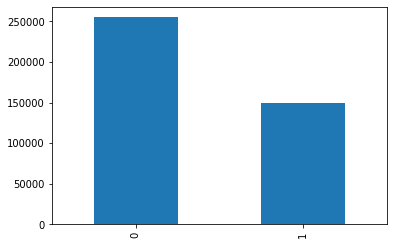

In [13]:
# non duplicate and duplicate question count plot 
train['is_duplicate'].value_counts().plot.bar()

In [14]:
# Unique question ids in the dataset
qid = pd.Series(train['qid1'].tolist()+train['qid2'].tolist())
print("No. of unique question ids : ", len(np.unique(qid)))
# Duplicate question ids in the dataset
x = pd.Series(train['qid1'].tolist()+train['qid2'].tolist()).value_counts()>1
print("No. of repeated questions : ",x[x].shape[0])

# duplicate question pairs 
print("No. of duplicate question pairs : ",train.duplicated().sum())

No. of unique question ids :  537929
No. of repeated questions :  111778
No. of duplicate question pairs :  0


# Text Preprocessing

In [15]:
# Clean data using the built in cleaner in gensim
train['q1_clean'] = train['question1'].apply(lambda x: gensim.utils.simple_preprocess(x))
train['q2_clean'] = train['question2'].apply(lambda x: gensim.utils.simple_preprocess(x))

In [16]:
# def preprocess(q):
    
#     q = str(q).lower().strip()
    
#     # Replace certain special characters with their string equivalents
#     q = q.replace('%', ' percent')
#     q = q.replace('$', ' dollar ')
#     q = q.replace('₹', ' rupee ')
#     q = q.replace('€', ' euro ')
#     q = q.replace('@', ' at ')
    
#     # The pattern '[math]' appears around 900 times in the whole dataset.
#     q = q.replace('[math]', '')
    
#     # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
#     q = q.replace(',000,000,000 ', 'b ')
#     q = q.replace(',000,000 ', 'm ')
#     q = q.replace(',000 ', 'k ')
#     q = q.replace('?', '')
#     q = q.replace('/', ' ')
#     q = re.sub(r'([0-9]+)000000000', r'\1b', q)
#     q = re.sub(r'([0-9]+)000000', r'\1m', q)
#     q = re.sub(r'([0-9]+)000', r'\1k', q)
    
#     # Decontracting words
#     # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
#     # https://stackoverflow.com/a/19794953
#     contractions = { 
#     "ain't": "am not",
#     "aren't": "are not",
#     "can't": "can not",
#     "can't've": "can not have",
#     "'cause": "because",
#     "could've": "could have",
#     "couldn't": "could not",
#     "couldn't've": "could not have",
#     "didn't": "did not",
#     "doesn't": "does not",
#     "don't": "do not",
#     "hadn't": "had not",
#     "hadn't've": "had not have",
#     "hasn't": "has not",
#     "haven't": "have not",
#     "he'd": "he would",
#     "he'd've": "he would have",
#     "he'll": "he will",
#     "he'll've": "he will have",
#     "he's": "he is",
#     "how'd": "how did",
#     "how'd'y": "how do you",
#     "how'll": "how will",
#     "how's": "how is",
#     "i'd": "i would",
#     "i'd've": "i would have",
#     "i'll": "i will",
#     "i'll've": "i will have",
#     "i'm": "i am",
#     "i've": "i have",
#     "isn't": "is not",
#     "it'd": "it would",
#     "it'd've": "it would have",
#     "it'll": "it will",
#     "it'll've": "it will have",
#     "it's": "it is",
#     "let's": "let us",
#     "ma'am": "madam",
#     "mayn't": "may not",
#     "might've": "might have",
#     "mightn't": "might not",
#     "mightn't've": "might not have",
#     "must've": "must have",
#     "mustn't": "must not",
#     "mustn't've": "must not have",
#     "needn't": "need not",
#     "needn't've": "need not have",
#     "o'clock": "of the clock",
#     "oughtn't": "ought not",
#     "oughtn't've": "ought not have",
#     "shan't": "shall not",
#     "sha'n't": "shall not",
#     "shan't've": "shall not have",
#     "she'd": "she would",
#     "she'd've": "she would have",
#     "she'll": "she will",
#     "she'll've": "she will have",
#     "she's": "she is",
#     "should've": "should have",
#     "shouldn't": "should not",
#     "shouldn't've": "should not have",
#     "so've": "so have",
#     "so's": "so as",
#     "that'd": "that would",
#     "that'd've": "that would have",
#     "that's": "that is",
#     "there'd": "there would",
#     "there'd've": "there would have",
#     "there's": "there is",
#     "they'd": "they would",
#     "they'd've": "they would have",
#     "they'll": "they will",
#     "they'll've": "they will have",
#     "they're": "they are",
#     "they've": "they have",
#     "to've": "to have",
#     "wasn't": "was not",
#     "we'd": "we would",
#     "we'd've": "we would have",
#     "we'll": "we will",
#     "we'll've": "we will have",
#     "we're": "we are",
#     "we've": "we have",
#     "weren't": "were not",
#     "what'll": "what will",
#     "what'll've": "what will have",
#     "what're": "what are",
#     "what's": "what is",
#     "what've": "what have",
#     "when's": "when is",
#     "when've": "when have",
#     "where'd": "where did",
#     "where's": "where is",
#     "where've": "where have",
#     "who'll": "who will",
#     "who'll've": "who will have",
#     "who's": "who is",
#     "who've": "who have",
#     "why's": "why is",
#     "why've": "why have",
#     "will've": "will have",
#     "won't": "will not",
#     "won't've": "will not have",
#     "would've": "would have",
#     "wouldn't": "would not",
#     "wouldn't've": "would not have",
#     "y'all": "you all",
#     "y'all'd": "you all would",
#     "y'all'd've": "you all would have",
#     "y'all're": "you all are",
#     "y'all've": "you all have",
#     "you'd": "you would",
#     "you'd've": "you would have",
#     "you'll": "you will",
#     "you'll've": "you will have",
#     "you're": "you are",
#     "you've": "you have"
#     }

#     q_decontracted = []

#     for word in q.split():
#         if (word.strip() not in stop_words):
#             if (word in contractions):
#                 word = contractions[word]
        
#         q_decontracted.append(word)
        

#     q = ' '.join(q_decontracted)
# #     non_stop = []
# #     for word in q.split():
# #         if (word.strip() not in stop_words):
# #             non_stop.append(word)
            
# #     q = ' '.join(non_stop)
#     q = q.replace("'ve", " have")
#     q = q.replace("n't", " not")
#     q = q.replace("'re", " are")
#     q = q.replace("'ll", " will")
    
#     # Removing HTML tags
#     q = BeautifulSoup(q)
#     q = q.get_text()
    
#     # Remove punctuations
#     pattern = re.compile('\W')
#     q = re.sub(pattern, ' ', q).strip()

    
#     return q

In [17]:
# %%time
# train['question1'] = train['question1'].apply(preprocess)
# train['question2'] = train['question2'].apply(preprocess)

In [18]:
# train['question1'] = train['question1'].apply(lambda x: x.split())
# train['question2'] = train['question2'].apply(lambda x: x.split())

In [19]:
# only question1 and question2 extracted from dataframe
ques_df = train[['q1_clean','q2_clean', 'is_duplicate']]
ques_df.head()

,q1_clean,q2_clean,is_duplicate
0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0
1,"[what, is, the, story, of, kohinoor, koh, noor...","[what, would, happen, if, the, indian, governm...",0
2,"[how, can, increase, the, speed, of, my, inter...","[how, can, internet, speed, be, increased, by,...",0
3,"[why, am, mentally, very, lonely, how, can, so...","[find, the, remainder, when, math, math, is, d...",0
4,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0


*After prepocessing some null values came in*

In [20]:
count = 0
for i in ques_df['q1_clean'].values:
    if(len(i)==0):
        print(count)
    count+=1

3306
13016
20794
31239
54029
96725
104101
108977
115346
134402
151921
158777
169289
175583
182614
189658
190569
199109
208483
213218
217456
254159
273063
301581
342157
351786
357125
402420


In [21]:
count = 0
for i in ques_df['q2_clean'].values:
    if(len(i)==0):
        print(count)
    count+=1

20072
34755
47056
124820
198912
222728
226923
384290


In [22]:
ques_df['q1_clean'].iloc[402420]

[]

In [23]:
ques_df.shape

(404287, 3)

In [24]:
ques_df['q1_clean'] = ques_df['q1_clean'].apply(lambda x: np.nan if len(x)==0 else x)
ques_df['q2_clean'] = ques_df['q2_clean'].apply(lambda x: np.nan if len(x)==0 else x)

In [25]:
ques_df.dropna(axis = 0, inplace=True)

In [26]:
question = list(ques_df['q1_clean'])+list(ques_df['q2_clean'])


In [27]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(sentences=question, vector_size=300, window=10, min_count=2, workers=4)
model.build_vocab(question)

CPU times: user 3min 2s, sys: 1 s, total: 3min 3s
Wall time: 56.1 s


In [28]:
%%time
model.train(question, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 2min 49s, sys: 1.01 s, total: 2min 50s
Wall time: 48 s


(30346006, 42081155)

In [29]:
model.wv.most_similar('google')

[('firefox', 0.5036675930023193),
 ('dropbox', 0.4534209370613098),
 ('microsoft', 0.44438791275024414),
 ('amazon', 0.4404872953891754),
 ('facebook', 0.4143190383911133),
 ('backups', 0.40237855911254883),
 ('ibm', 0.39561042189598083),
 ('yelp', 0.38672056794166565),
 ('webpage', 0.38671866059303284),
 ('click', 0.3829178214073181)]

In [30]:
words = set(model.wv.index_to_key )
# words

In [31]:
ques_df["question_1"] = ques_df["q1_clean"].apply(lambda text: np.mean([model.wv[word] for word in text if word in model.wv], axis  =0))

In [32]:
ques_df["question_2"] = ques_df["q2_clean"].apply(lambda text: np.mean([model.wv[word] for word in text if word in model.wv],axis = 0))

In [33]:
%%time
ques_df['new'] = ques_df.apply(lambda x : np.hstack([x['question_1'],x['question_2']]), axis = 1)

CPU times: user 7.92 s, sys: 625 ms, total: 8.54 s
Wall time: 8.53 s


In [34]:
X = ques_df['new'].values
y = np.array(ques_df['is_duplicate'].values)

In [35]:
X.shape, y.shape

((404251,), (404251,))

In [36]:
# count = 0
# index = []
# for ele in x:
#     if ele.dtype!='float32':
#         index.append(count)
#     count+=1
# index      

In [37]:
x_updated = []
y_updated = []
for i, ele in enumerate(ques_df['new'].values):
    if ele.dtype=='float32':
        x_updated.append(ele)
        y_updated.append(y[i])

In [38]:
x_updated = np.array(x_updated)
y_updated = np.array(y_updated)
x_updated.shape, y_updated.shape


((404247, 600), (404247,))

In [39]:
Xtrain,Xtest,ytrain,ytest = train_test_split(x_updated, y_updated,test_size = 0.2,random_state = 24)

In [40]:
Xtrain.shape, ytrain.shape

((323397, 600), (323397,))

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
pre = lr.predict(Xtest)
acc =accuracy_score(ytest,pre)
print(acc*100)



72.84848484848484


In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(Xtrain,ytrain)
pre = rf.predict(Xtest)
acc =accuracy_score(ytest,pre)
print(acc*100)

79.74025974025975


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define the keras model
model = Sequential()
model.add(Dense(512, input_shape = (Xtrain.shape[1],), activation='relu'))
model.add(Dense(288, activation='relu'))
model.add(Dense(144, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(Xtrain,ytrain, epochs=15, batch_size=10, validation_data = (Xtest, ytest))

2022-11-11 11:02:23.453592: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-11 11:02:24.048661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
32340/32340 [==============================] - 201s 6ms/step - loss: 0.4917 - accuracy: 0.7504 - val_loss: 0.4578 - val_accuracy: 0.7704
Epoch 2/15
32340/32340 [==============================] - 203s 6ms/step - loss: 0.4418 - accuracy: 0.7802 - val_loss: 0.4394 - val_accuracy: 0.7819
Epoch 3/15
32340/32340 [==============================] - 201s 6ms/step - loss: 0.4152 - accuracy: 0.7945 - val_loss: 0.4336 - val_accuracy: 0.7887
Epoch 4/15
32340/32340 [==============================] - 203s 6ms/step - loss: 0.3922 - accuracy: 0.8089 - val_loss: 0.4287 - val_accuracy: 0.7907
Epoch 5/15
32340/32340 [==============================] - 208s 6ms/step - loss: 0.3715 - accuracy: 0.8211 - val_loss: 0.4339 - val_accuracy: 0.7963
Epoch 6/15
32340/32340 [==============================] - 204s 6ms/step - loss: 0.3527 - accuracy: 0.8312 - val_loss: 0.4242 - val_accuracy: 0.7937
Epoch 7/15
32340/32340 [==============================] - 202s 6ms/step - loss: 0.3364 - accuracy: 0.8404 - val_